In [ ]:
!pip install -r requirements.txt
!pip install requests




In [1]:
%load_ext autoreload
%autoreload 2
from downloader import download_files


In [17]:
class Arg():
    def __init__(self,contains,scene,endings=None,max_file_size=1):
        # This is used as the args that were passed by cmd in original code. 
        # based on https://github.com/apple/ml-hypersim/tree/main/contrib/99991 
        """Contains: mandatory list of strings that must ALL appear in file name to be downloaded
            endings: list of strings where at least ONE should appear in file name to be downloaded
            max_file_size: max size given in GO"""
        if endings is None:
            endings=["."]
        self.directory="downloads" # Download path
        self.overwrite=False
        self.contains=contains # [['ai_001_001'], ['frame.0000']]
        self.scene=scene
        self.silent=True
        self.list=False
        self.endings=endings
        self.file_size_limit=max_file_size*(10**9)*10**9 # TODO: planned feature, "works" but first downloads the color images, then fina¨
                                                         # if enough space downloads the corresponding segmentations. For the expected behaviour we would need to rewrite the downloader.py 
        

In [19]:
# Be carefull, running this cell will start the download of ai_001_001. after around 1 mins (depending on connection), you should manually stop this cell as 
# otherwise it can take quite a while. I will try to see how to handle this from python but it doesn't seem trivial.
# Also a planned feature would be to add a limit
# args = Arg(contains=[['ai_001_001'], ['frame.0000']],endings=[[".color.hdf5"],[".semantic"],[".depth_meters.hdf5"]],max_file_size=1) # For now we allow previews, but will be removed for final code.
args = Arg(scene="ai_001_002",contains=[['ai_002_001'], ['frame.0000']],endings=[[".color.hdf5"],["."]],max_file_size=1) 
download_files(args)

[<ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_frame_indices.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=2848>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_look_at_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_orientations.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=9248>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_002/_detail/cam_00/metadata_camera.csv' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=54>, <ZipInfo filename='ai_001_002/_detail/cam_01/camera_keyframe_frame_indices.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=2848>, <ZipInfo filename='ai_001_002/_detail/cam_01/camera_keyframe_look_at_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_

In [2]:
import numpy as np
import h5py
from matplotlib import pyplot as plt


In [22]:
           
filename = "./downloads/ai_001_002/images/scene_cam_00_final_hdf5/frame.0023.color.hdf5" #"./downloads/ai_001_001/images/scene_cam_00_final_hdf5/frame.0000.color.hdf5"
f = h5py.File(filename, "r")

filename_semantics = "./downloads/ai_001_002/images/scene_cam_00_geometry_hdf5/frame.0023.semantic.hdf5" #"./downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0000.semantic.hdf5"
f_semantics = h5py.File(filename_semantics, "r")

filename_depth = "./downloads/ai_001_002/images/scene_cam_00_geometry_hdf5/frame.0023.depth_meters.hdf5"#"./downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0000.depth_meters.hdf5"
f_depth  = h5py.File(filename_depth , "r")

In [23]:
def remap_data(np_array,wanted_max):
    return (np_array* int(wanted_max/np_array.max() )).astype(np.uint8)
def display_image(hdf5_dataset, should_remap=True,remap_func=None):
    if remap_func is None:
        remap_func=remap_data
    np_data = np.array(hdf5_dataset)
    if should_remap:
        np_data = remap_data(np_data,255)
    plt.imshow(np_data)
    plt.show()

def print_infos(np_array,name="Data"):
    print(f"{name} information: shape:{np_array.shape} ,  dtype: {np_array.dtype}, min:{np_array.min()}, max:{np_array.max()}  ")


     

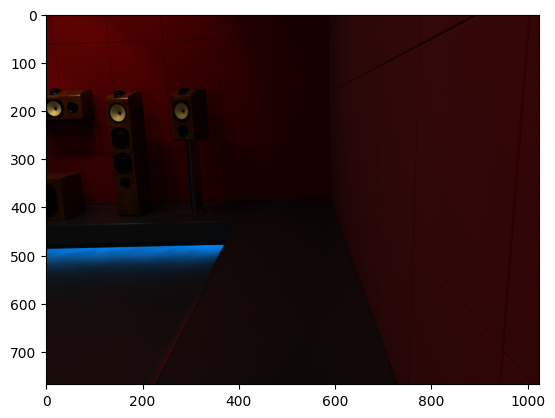

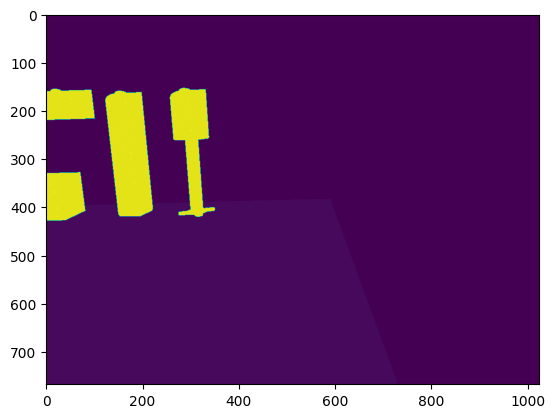

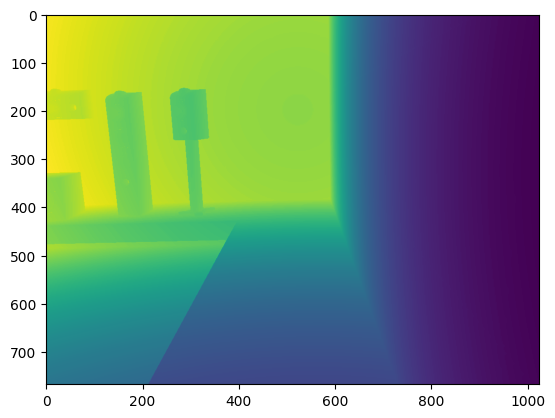

In [24]:
display_image(f["dataset"])
display_image(f_semantics["dataset"])
display_image(f_depth["dataset"])

In [ ]:
print_infos(f["dataset"],"RGB")
print_infos(f_semantics["dataset"],"semantics")
print_infos(f_depth["dataset"],"depth")


In [10]:
data = np.array(f["dataset"])
data= data * int(255/data.max() )
data = data.astype(np.uint8)

data_sem = np.array(f_semantics["dataset"])
data_sem= data_sem * int(254/data_sem.max() )
data_sem = data_sem.astype(np.uint8)

In [22]:
print(f"Semantic Data information:  data_sem.shape:{data_sem.shape} ,data_sem.dtype: {data_sem.dtype},data_sem.min:{data_sem.min()},data_sem.max:{data_sem.max()}  ")


Data information:	    data.shape:(768, 1024, 3) , data.dtype: uint8,data.min:0,data.max:254  
Semantic Data information:  data_sem.shape:(768, 1024) ,data_sem.dtype: uint8,data_sem.min:6,data_sem.max:250  


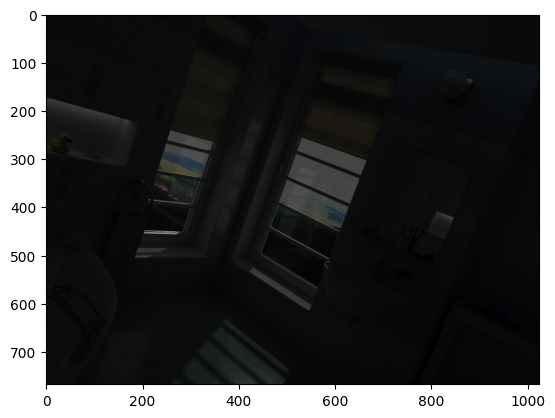

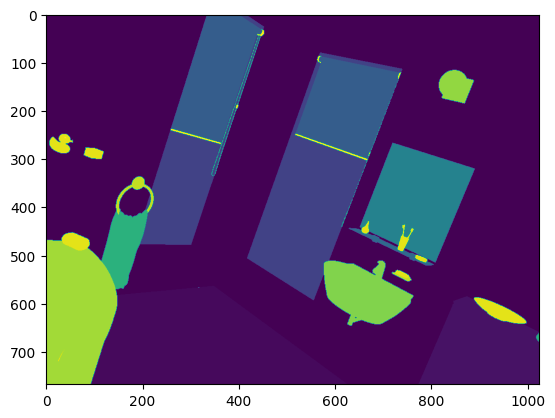

In [12]:
from matplotlib import pyplot as plt
plt.imshow(data_sem)
plt.show()

In [12]:


t = np.array(f_semantics["dataset"])
t.min()
t.max()

40

In [13]:
print(t.min())
print(t.max())

-1
40


In [3]:
import os
import argparse
import requests
import zipfile
zipfile.ZipExtFile.MIN_READ_SIZE = 2 ** 20


In [4]:
url="https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_002.zip"

class WebFile:
    def __init__(self, url, session):
        with session.head(url) as response:
            size = int(response.headers["content-length"])

        self.url = url
        self.session = session
        self.offset = 0
        self.size = size

    def seekable(self):
        return True

    def tell(self):
        return self.offset

    def available(self):
        return self.size - self.offset

    def seek(self, offset, whence=0):
        if whence == 0:
            self.offset = offset
        elif whence == 1:
            self.offset = min(self.offset + offset, self.size)
        elif whence == 2:
            self.offset = max(0, self.size + offset)

    def read(self, n=None):
        if n is None:
            n = self.available()
        else:
            n = min(n, self.available())

        end_inclusive = self.offset + n - 1

        headers = {
            "Range": f"bytes={self.offset}-{end_inclusive}",
        }

        with self.session.get(self.url, headers=headers) as response:
            data = response.content

        self.offset += len(data)

        return data


session = requests.session()
f = WebFile(url, session)
z = zipfile.ZipFile(f)
print(z.infolist())

[<ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_frame_indices.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=2848>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_look_at_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_orientations.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=9248>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_002/_detail/cam_00/metadata_camera.csv' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=54>, <ZipInfo filename='ai_001_002/_detail/cam_01/camera_keyframe_frame_indices.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=2848>, <ZipInfo filename='ai_001_002/_detail/cam_01/camera_keyframe_look_at_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_

In [5]:
l = z.namelist()

In [6]:
def get_scenes(list):
    scenes_list=[]
    frames_list = []

    a=True
    for s in list:
        if ".color.hdf5" in s:
            scenes_list.append(s[-35:-33])
            frames_list.append(s[-15:-11])

    
    return set(frames_list),set(scenes_list)

In [12]:
URLS = [
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_001_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_002_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_003_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_004_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_005_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_006_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_007_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_008_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_009_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_010_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_011_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_012_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_012_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_012_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_012_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_012_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_012_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_013_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_013_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_013_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_013_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_013_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_013_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_013_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_014_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_014_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_014_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_015_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_016_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_017_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_018_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_019_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_019_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_019_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_019_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_019_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_019_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_019_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_019_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_021_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_021_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_021_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_021_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_021_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_021_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_021_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_022_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_023_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_011.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_012.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_013.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_014.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_015.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_016.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_017.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_018.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_024_019.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_011.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_012.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_013.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_014.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_015.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_016.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_017.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_018.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_019.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_026_020.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_027_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_028_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_028_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_028_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_028_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_028_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_028_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_028_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_028_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_029_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_029_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_029_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_029_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_029_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_030_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_031_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_031_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_031_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_031_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_031_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_031_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_031_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_031_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_032_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_032_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_032_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_032_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_032_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_032_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_032_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_032_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_033_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_033_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_033_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_033_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_033_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_033_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_033_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_033_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_034_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_034_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_034_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_034_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_035_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_036_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_036_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_036_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_036_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_036_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_036_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_036_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_036_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_037_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_038_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_038_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_038_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_038_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_038_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_038_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_038_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_039_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_041_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_042_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_042_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_042_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_042_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_042_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_043_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_044_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_045_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_045_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_045_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_045_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_045_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_045_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_046_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_046_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_046_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_046_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_046_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_046_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_046_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_046_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_047_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_048_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_050_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_050_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_050_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_050_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_050_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_051_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_051_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_051_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_051_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_051_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_052_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_012.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_013.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_014.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_016.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_017.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_018.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_019.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_053_020.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_054_010.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_001.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_002.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_003.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_004.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_005.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_006.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_007.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_008.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_009.zip",
    "https://docs-assets.developer.apple.com/ml-research/datasets/hypersim/v1/scenes/ai_055_010.zip",
]


In [19]:
class WebFile:
    def __init__(self, url, session):
        with session.head(url) as response:
            size = int(response.headers["content-length"])

        self.url = url
        self.session = session
        self.offset = 0
        self.size = size

    def seekable(self):
        return True

    def tell(self):
        return self.offset

    def available(self):
        return self.size - self.offset

    def seek(self, offset, whence=0):
        if whence == 0:
            self.offset = offset
        elif whence == 1:
            self.offset = min(self.offset + offset, self.size)
        elif whence == 2:
            self.offset = max(0, self.size + offset)

    def read(self, n=None):
        if n is None:
            n = self.available()
        else:
            n = min(n, self.available())

        end_inclusive = self.offset + n - 1

        headers = {
            "Range": f"bytes={self.offset}-{end_inclusive}",
        }

        with self.session.get(self.url, headers=headers) as response:
            data = response.content

        self.offset += len(data)

        return data

def download_files_me(url_list,max_file_size_GB,download_path="download/"):
    # Maybe todo, return a list of the files path/names, or a csv, for easier loading afterwards?
    downloaded_size = 0
    max_file_size_bytes = max_file_size_GB * (10**9)
    session = requests.session()
    for url in url_list:
        f = WebFile(url, session)
        z = zipfile.ZipFile(f)
        frames_list,cam_list = get_scenes(l)
        ai_name = url[-14:-4]
        for frame in frames_list:
            for cam in cam_list:
                rgb_file_name = f"{ai_name}/images/scene_cam_{cam}_final_hdf5/frame.{frame}.color.hdf5"
                depth_file_name = f"{ai_name}/images/scene_cam_{cam}_geometry_hdf5/frame.{frame}.depth_meters.hdf5"
                segmentation_file_name = f"{ai_name}/images/scene_cam_{cam}_geometry_hdf5/frame.{frame}.semantic.hdf5"
                file_names = [rgb_file_name,depth_file_name,segmentation_file_name]
                try:
                    for file_name in file_names:
                        res = z.extract(file_name, download_path)
                        path = os.path.join(download_path, file_name) 
                        downloaded_size+=os.path.getsize(path)
                        print(res)
                    
                    if downloaded_size >= max_file_size_bytes:

                        print(f"Maximum download size reached: {downloaded_size/(10**9)} / {max_file_size_bytes/(10**9)}")
                        
                        return 1
                except KeyError:
                    continue
                


[<ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_frame_indices.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=2848>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_look_at_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_orientations.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=9248>, <ZipInfo filename='ai_001_002/_detail/cam_00/camera_keyframe_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_002/_detail/cam_00/metadata_camera.csv' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=54>, <ZipInfo filename='ai_001_002/_detail/cam_01/camera_keyframe_frame_indices.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=2848>, <ZipInfo filename='ai_001_002/_detail/cam_01/camera_keyframe_look_at_positions.hdf5' filemode='-rwxrwxrwx' external_attr=0x8020 file_size=4448>, <ZipInfo filename='ai_001_

In [21]:
download_files_me(URLS,0.5,download_path="downloads/")

downloads/ai_001_001/images/scene_cam_00_final_hdf5/frame.0053.color.hdf5
downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0053.depth_meters.hdf5
downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0053.semantic.hdf5
downloads/ai_001_001/images/scene_cam_00_final_hdf5/frame.0008.color.hdf5
downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0008.depth_meters.hdf5
downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0008.semantic.hdf5
downloads/ai_001_001/images/scene_cam_00_final_hdf5/frame.0056.color.hdf5
downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0056.depth_meters.hdf5
downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0056.semantic.hdf5
downloads/ai_001_001/images/scene_cam_00_final_hdf5/frame.0044.color.hdf5
downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0044.depth_meters.hdf5
downloads/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0044.semantic.hdf5
downloads/ai_001_001/images/scene_cam_00_final_h

1